# Setup

In [1]:
IN_COLAB = False
try:
    from google.colab import drive
    drive.mount("/content/drive")
    ift3335 = "drive/MyDrive/IFT3335/"
    IN_COLAB = True
except:
    IN_COLAB = False

Mounted at /content/drive


In [2]:
import warnings

import nltk
import numpy as np
import pandas as pd
import torch
import transformers as ppb
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")

# Télécharger les ressources nécessaires pour NLTK
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
def extract_data(filepath):
    df = pd.read_csv(filepath, delimiter="\t", header=None)[1:]
    data = df[1]
    labels = [label.strip() == "OFF" for label in df[2]]

    return data, labels


# Training Functions

## Classical techniques

In [4]:
def prep_data(data, do_standardize=True, do_filter=True, do_trunkate=True, do_lemmatize=True):
    lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer("english")
    stop_words = set(stopwords.words("english"))
    data = list(data)

    words_to_delete = ["@USER", "URL"]
    for i in range(len(data)):
        # Delete unnecessary words
        for word in words_to_delete:
            data[i] = data[i].replace(word, "")

        # Standardize text
        if do_standardize:
            data[i] = data[i].strip().lower()

        # Tokenize
        tokens = word_tokenize(data[i])

        # Remove stop words and non-alphanumeric tokens
        if do_filter:
            tokens = filter(lambda token: token not in stop_words and token.isalnum(), tokens)

        # Lemmatize (trunkate words)
        if do_trunkate:
            if do_lemmatize:
                tokens = [lemmatizer.lemmatize(token) for token in tokens]
            else:
                tokens = [stemmer.stem(token) for token in tokens]

        # Update data
        data[i] = " ".join(tokens)

    return data


def train_data(data, labels):
    models = {
        "Decision Tree (Gini)": DecisionTreeClassifier(criterion="gini"),
        "Decision Tree (Entropy)": DecisionTreeClassifier(criterion="entropy"),
        "SVM (RBF kernel)": SVC(kernel="rbf"),
        "SVM (linear kernel)": SVC(kernel="linear"),
        "Multinomial Naive Bayes": MultinomialNB(),
        "Gaussian Naive Bayes": GaussianNB(),
        "Random Forest (10 trees, d=None)": RandomForestClassifier(n_estimators=10, max_depth=None),
        "Random Forest (100 trees, d=None)": RandomForestClassifier(n_estimators=100, max_depth=None),
        "Random Forest (500 trees, d=None)": RandomForestClassifier(n_estimators=500, max_depth=None),
        "Random Forest (10 trees, d=20)": RandomForestClassifier(n_estimators=10, max_depth=20),
        "Random Forest (100 trees, d=20)": RandomForestClassifier(n_estimators=100, max_depth=20),
        "Random Forest (500 trees, d=20)": RandomForestClassifier(n_estimators=500, max_depth=20),
        "Random Forest (10 trees, d=100)": RandomForestClassifier(n_estimators=10, max_depth=100),
        "Random Forest (100 trees, d=100)": RandomForestClassifier(n_estimators=100, max_depth=100),
        "Random Forest (500 trees, d=100)": RandomForestClassifier(n_estimators=500, max_depth=100),
        "MLP (relu, 100 layers)": MLPClassifier(activation="relu", hidden_layer_sizes=(100,)),
        "MLP (relu, 250 layer)": MLPClassifier(activation="relu", hidden_layer_sizes=(250,)),
        "MLP (relu, 500 layer)": MLPClassifier(activation="relu", hidden_layer_sizes=(500,)),
        "MLP (logistic, 100 layer)": MLPClassifier(activation="logistic", hidden_layer_sizes=(100,)),
        "MLP (logistic, 250 layer)": MLPClassifier(activation="logistic", hidden_layer_sizes=(250,)),
        "MLP (logistic, 500 layer)": MLPClassifier(activation="logistic", hidden_layer_sizes=(500,)),
    }

    # Split data into train and test
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.3, random_state=42)
    count_vectorizer = CountVectorizer()
    tfidf_vectorizer = TfidfVectorizer()

    # Vectorize data with count
    data_train_count = count_vectorizer.fit_transform(data_train)
    data_test_count = count_vectorizer.transform(data_test)

    # Vectorize data with tfidf
    data_train_tfidf = tfidf_vectorizer.fit_transform(data_train)
    data_test_tfidf = tfidf_vectorizer.transform(data_test)

    for key, value in models.items():
        if key == "Gaussian Naive Bayes":
            data_train_count = data_train_count.toarray()
            data_test_count = data_test_count.toarray()
            data_train_tfidf = data_train_tfidf.toarray()
            data_test_tfidf = data_test_tfidf.toarray()

        print("====================")
        print(f"Using {key} method")
        print("Fit model with count: ")
        value.fit(data_train_count, labels_train)
        predicted = value.score(data_test_count, labels_test)
        scores = cross_val_score(value, data_test_count, labels_test)
        print("| Score:", predicted)
        print("| Cross-val score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

        print("Fit model with tfidf: ")
        value.fit(data_train_tfidf, labels_train)
        predicted = value.score(data_test_tfidf, labels_test)
        scores = cross_val_score(value, data_test_tfidf, labels_test)
        print("| Score:", predicted)
        print("| Cross-val score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


## Bert/DistilBert

In [5]:
def bert_features(data, labels, batch_size=2000, use_original_bert=True):
    # DistilBERT vs BERT model
    if use_original_bert:
        model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, "bert-base-uncased")
    else:
        model_class, tokenizer_class, pretrained_weights = (
            ppb.DistilBertModel,
            ppb.DistilBertTokenizer,
            "distilbert-base-uncased",
        )

    # Load pretrained model/tokenizer
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)

    # Move model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    model.to(device)

    features = []
    for i in range(0, len(data), batch_size):
        batch_data = data[i : i + batch_size]

        # Tokenize data
        tokenized = batch_data.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

        # Pad values to normalize length of tokens
        max_len = max(len(token) for token in tokenized)
        padded = np.array([token + [0] * (max_len - len(token)) for token in tokenized.values])

        # Create attention mask to ignore padding
        attention_mask = np.where(padded != 0, 1, 0)
        input_ids = torch.tensor(padded).to(device)
        attention_mask = torch.tensor(attention_mask).to(device)

        with torch.no_grad():
            last_hidden_states = model(input_ids, attention_mask=attention_mask)

        # Get embedding of samples
        features.extend(last_hidden_states[0][:, 0, :].cpu().numpy())

    del model, input_ids, attention_mask, last_hidden_states
    return np.array(features)


def eval_bert(
    features,
    labels,
    use_original_bert=True,
    C=0.105,
    solver="saga",
    penalty="elasticnet",
    l1_ratio=0.25,
    solver_max_iter=100,
    do_search_param=False,
):
    # Split data into train and test
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels, test_size=0.3, random_state=42
    )

    # Fit using LogisticRegression
    if do_search_param:
        print("Searching for best regression parameters...")

        parameters = {
            "C": np.linspace(0.05, 0.11, 6),
            "solver": "saga",
            "penalty": "elasticnet",
            "l1_ratio": [0, 0.25, 0.5, 0.75, 1],
            "max_iter": [100, 500, 1000],
        }
        grid_search = GridSearchCV(LogisticRegression(), parameters)
        grid_search.fit(train_features, train_labels)

        print(f"Best parameters found: {grid_search.best_params_}")
        C = grid_search.best_params_["C"]
        solver = grid_search.best_params_["solver"]
        penalty = grid_search.best_params_["penalty"]
        l1_ratio = grid_search.best_params_["l1_ratio"]
        solver_max_iter = grid_search.best_params_["max_iter"]

    lr_clf = LogisticRegression(C=C, solver=solver, penalty=penalty, l1_ratio=l1_ratio, max_iter=solver_max_iter)
    lr_clf.fit(train_features, train_labels)
    score = lr_clf.score(test_features, test_labels)

    print("====================")
    print(
        f"Using {'BERT' if use_original_bert else 'DistilBERT'} method (C={C}, solver={solver}, max_iter={solver_max_iter}, penalty={penalty}, l1_ratio={l1_ratio})"
    )
    print("| Score:", score)


# Generating Results

In [ ]:
# Testing data preparation parameters
def compare_prep(data, labels):
    from itertools import product

    # Define the tuple of boolean values
    bool_tuple = (True, False)

    # Generate all combinations of boolean values
    for combo in product(bool_tuple, repeat=3):
        do_standardize, do_filter, do_trunkate = combo
        print("====================")
        print(f"(do_standardize, do_filter, do_trunkate) = {combo}")
        processed_data = prep_data(data, do_standardize, do_filter, do_trunkate)
        train_data(processed_data, labels)


def compare_stemmer_lemmatizer(data, labels):
    print("====================")
    print("Using lemmatizer")
    processed_data = prep_data(data, do_lemmatize=True)
    train_data(processed_data, labels)

    print("====================")
    print("Using stemming")
    processed_data = prep_data(data, do_lemmatize=False)
    train_data(processed_data, labels)


def compare_bert(data, labels):
    data = list(data)
    words_to_delete = ["@USER", "URL"]
    for i in range(len(data)):
        # Delete unnecessary words
        for word in words_to_delete:
            data[i] = data[i].replace(word, "")
        data[i].strip()

    data = pd.Series(data)
    for use_original_bert in [True, False]:
        features = bert_features(data, labels, batch_size=250, use_original_bert=use_original_bert)
        eval_bert(features, labels, use_original_bert)


In [ ]:
data, labels = extract_data(f"{ift3335}/offenseval-training-v1.tsv")

In [ ]:
# compare_prep(data, labels)
# compare_stemmer_lemmatizer(data, labels)
compare_bert(data, labels)

Using BERT method (C=0.105, solver=saga, max_iter=100, penalty=elasticnet, l1_ratio=0.25)
| Score: 0.7555387713997986
Using DistilBERT method (C=0.105, solver=saga, max_iter=100, penalty=elasticnet, l1_ratio=0.25)
| Score: 0.7671198388721048


# Running

In [6]:
def run_classical(data, labels, model):
    models = {
        "decisiontree_gini": DecisionTreeClassifier(criterion="gini"),
        "decisiontree_entropy": DecisionTreeClassifier(criterion="entropy"),
        "svm_rbf": SVC(kernel="rbf"),
        "svm_linear": SVC(kernel="linear"),
        "naivebayes_multinomial": MultinomialNB(),
        "naivebayes_gaussian": GaussianNB(),
        "randomforest": RandomForestClassifier(n_estimators=100, max_depth=None),
        "mlp": MLPClassifier(activation="logistic", hidden_layer_sizes=(100,)),
    }

    # Split data into train and test
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.3, random_state=42)
    count_vectorizer = CountVectorizer()
    tfidf_vectorizer = TfidfVectorizer()

    # Vectorize data with count
    data_train_count = count_vectorizer.fit_transform(data_train)
    data_test_count = count_vectorizer.transform(data_test)

    value = models[model]
    if model == "naivebayes_gaussian":
        data_train_count = data_train_count.toarray()
        data_test_count = data_test_count.toarray()

    print("====================")
    print(f"Using {model} method")
    value.fit(data_train_count, labels_train)
    predicted = value.score(data_test_count, labels_test)
    scores = cross_val_score(value, data_test_count, labels_test)
    print("| Score:", predicted)
    print("| Cross-val score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


def run(model, path_to_data=f"{ift3335}/offenseval-training-v1.tsv", batch_size=250):
    model = model.lower()
    models = [
        "decisiontree_gini",
        "decisiontree_entropy",
        "svm_rbf",
        "svm_linear",
        "naivebayes_multinomial",
        "naivebayes_gaussian",
        "randomforest",
        "mlp",
        "bert",
        "distilbert",
    ]

    if model not in models:
        print("Model not available...")
        print("Here are the available models:")
        print(models)
        return

    data, labels = extract_data(path_to_data)
    if model == "bert" or model == "distilbert":
        print("Pre-processing data...")
        data = list(data)
        words_to_delete = ["@USER", "URL"]
        for i in range(len(data)):
            # Delete unnecessary words
            for word in words_to_delete:
                data[i] = data[i].replace(word, "")
            data[i].strip()
        data = pd.Series(data)

        use_original_bert = model == "bert"
        print("IMPORTANT: If there is a crash, reduce batch size")
        print("Training model, it might take some time...")
        features = bert_features(data, labels, batch_size=batch_size, use_original_bert=use_original_bert)
        eval_bert(features, labels, use_original_bert)
    else:
        print("Pre-processing data...")
        processed_data = prep_data(data, do_lemmatize=False)
        run_classical(processed_data, labels, model)


In [11]:
# models available = [ "decisiontree_gini", "decisiontree_entropy", "svm_rbf", "svm_linear", "naivebayes_multinomial", "naivebayes_gaussian", "randomforest", "mlp", "bert", "distilbert" ]
model = "decisiontree_gini"
path_to_data = f"{ift3335}/offenseval-training-v1.tsv"

# Only used for bert/distilbert models
# 1500 should use around 10-12GB of VRAM on a T4 GPU with 15GB of VRAM
batch_size = 1500

run(model, path_to_data, batch_size)

Pre-processing data...
Using decisiontree_gini method
| Score: 0.736404833836858
| Cross-val score: 0.714 (+/- 0.02)


# Analysis

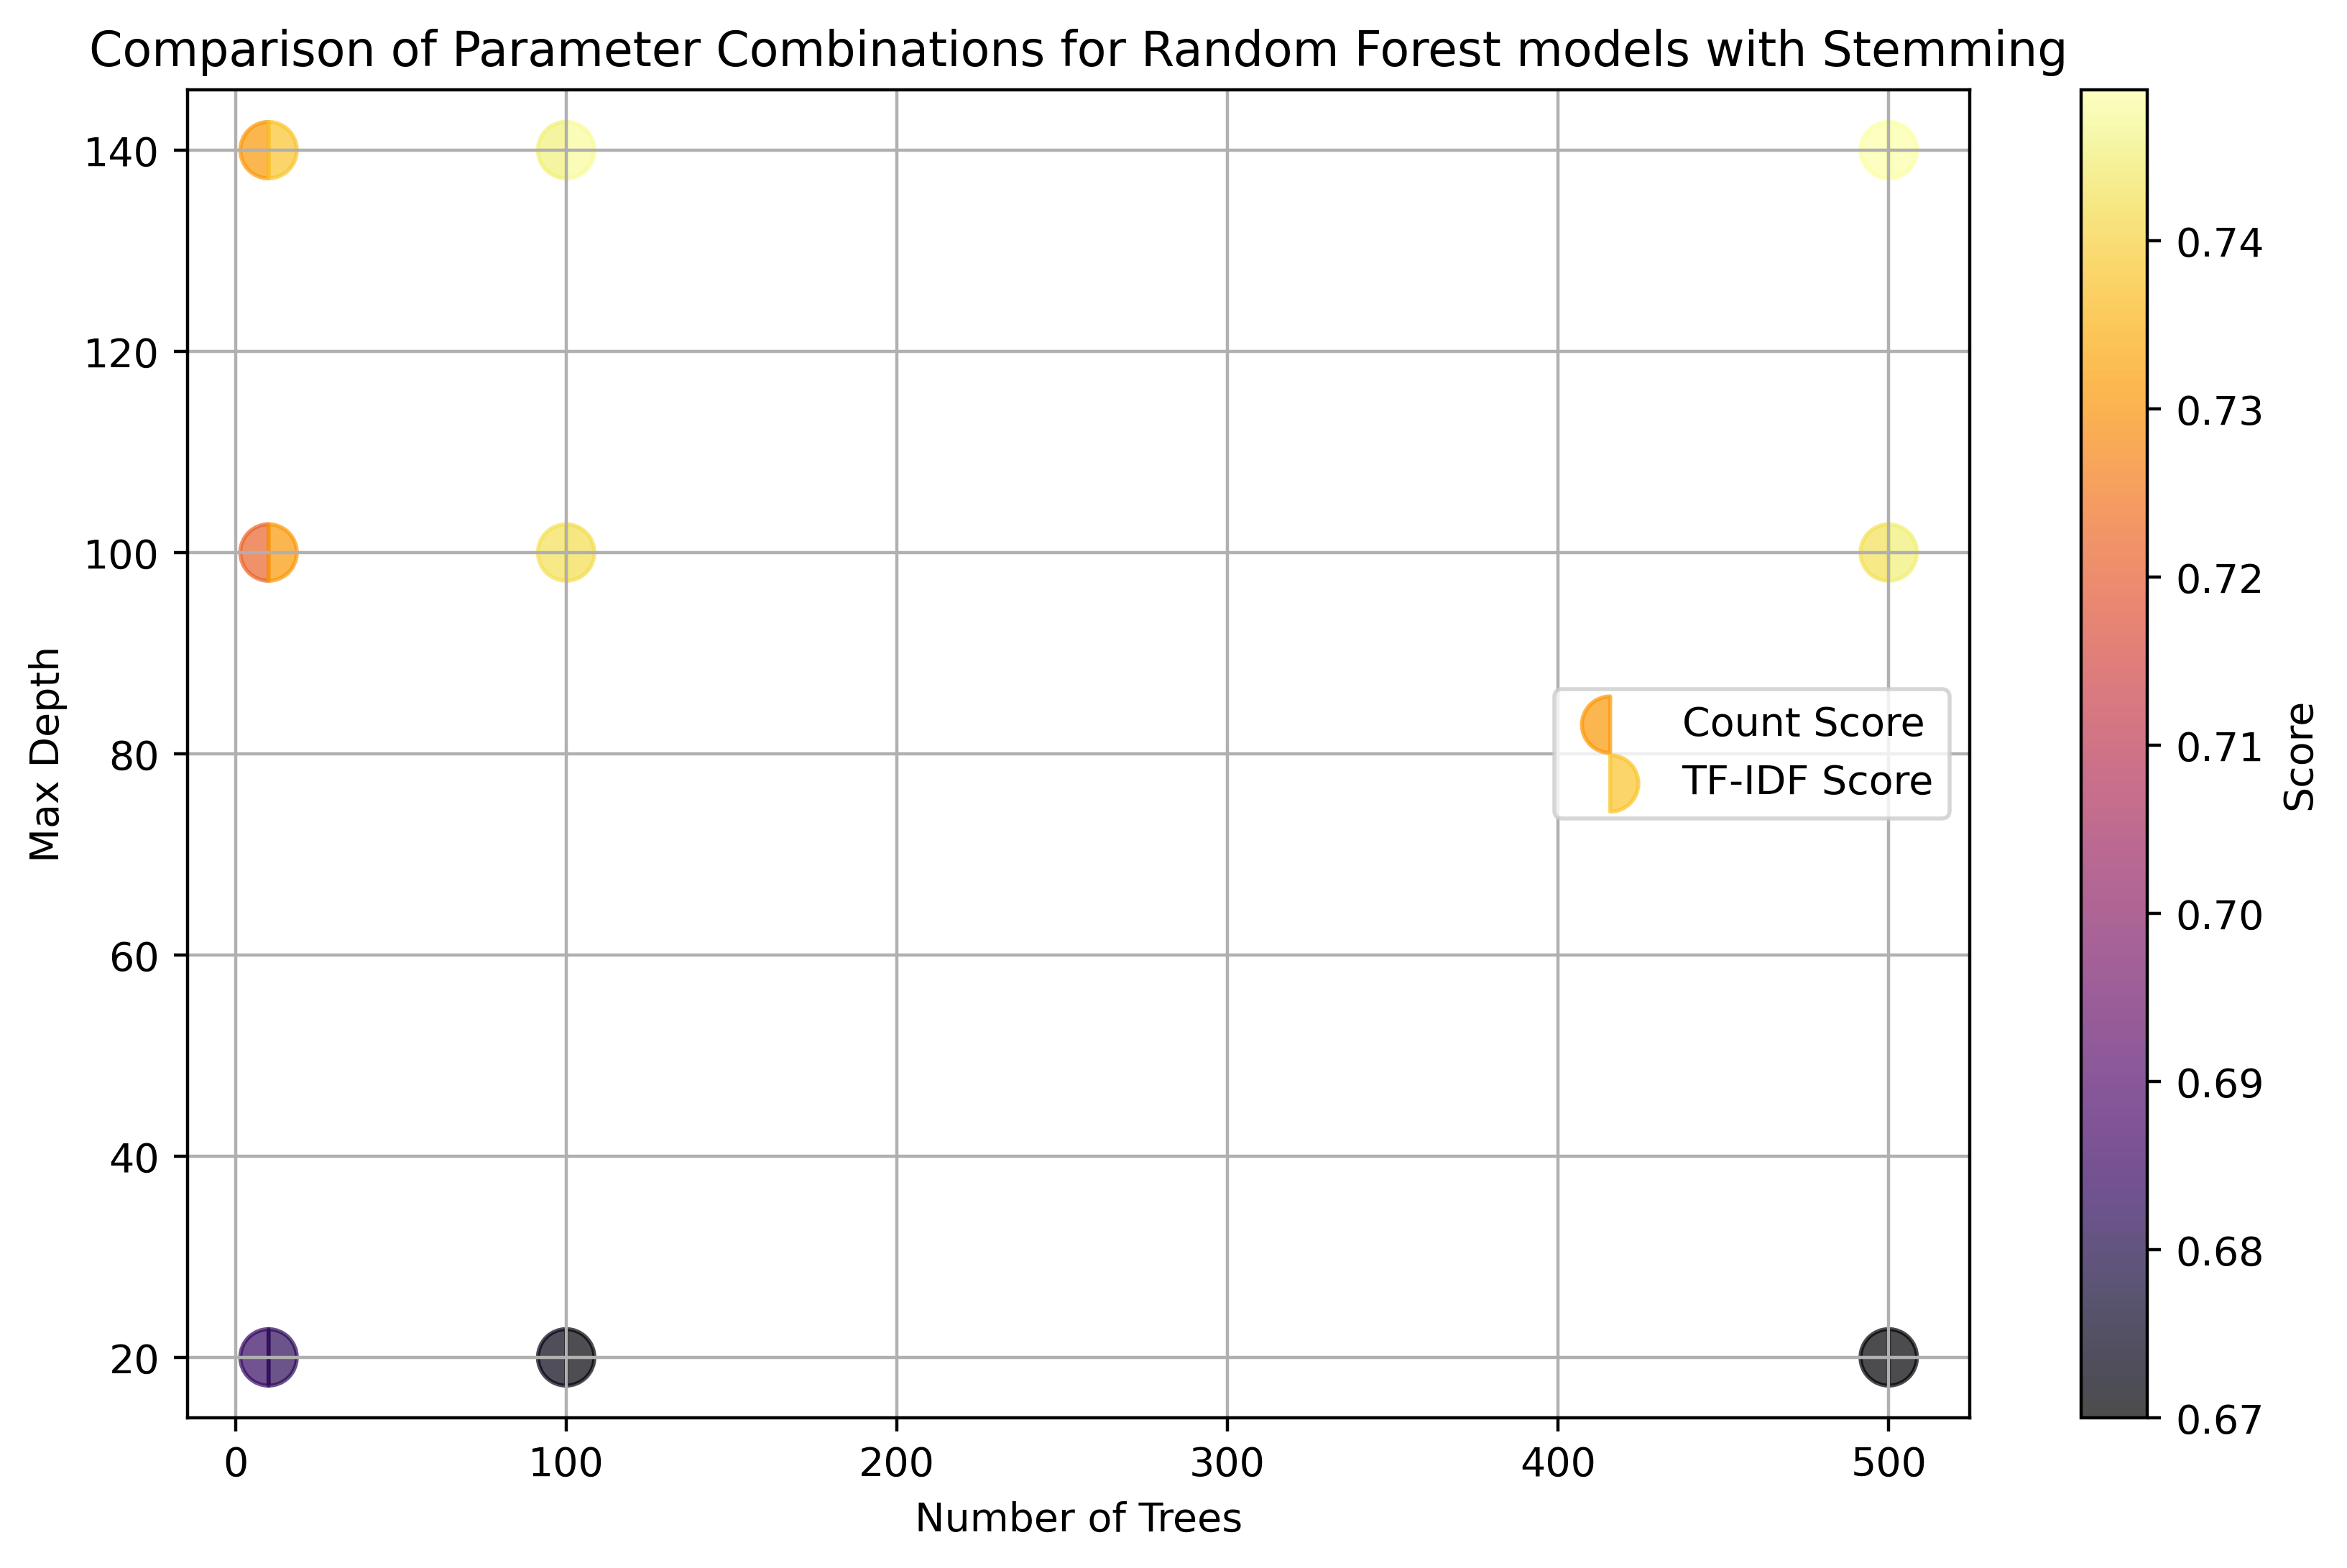

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
mpl.rcParams['figure.dpi'] = 400

# Data
trees = [10, 10, 10, 100, 100, 100, 500, 500, 500]
d_values = [None, 20, 100, None, 20, 100, None, 20, 100]

is_lemmatizer = False

if is_lemmatizer:
    # Lemmatizer scores
    method = "Lemmatizer"
    scores_count = [0.739,0.676,0.729,0.752,0.669,0.748,0.755,0.669,0.744]
    scores_tfidf = [0.731,0.682,0.725,0.753,0.669,0.739,0.748,0.668,0.737]
else:
    # Stemming scores
    method = "Stemming"
    scores_count = [0.737,0.685,0.727,0.753,0.673,0.750,0.757,0.670,0.750]
    scores_tfidf = [0.738,0.682,0.731,0.748,0.671,0.742,0.749,0.670,0.745]


d_values = [140 if value is None else value for value in d_values]

# Convert scores to numpy arrays for easier manipulation
scores_count = np.array(scores_count)
scores_tfidf = np.array(scores_tfidf)

# Create a sensitive colormap
cmap = plt.cm.inferno  # You can choose any other colormap as per your preference

# Plotting scores_count
plt.figure(figsize=(10, 6))
plt.scatter(trees, d_values, s=200, marker=MarkerStyle("o", fillstyle="left"), c=scores_count, cmap=cmap, alpha=0.7, label='Count Score')

# Plotting scores_tfidf
plt.scatter(trees, d_values, s=200, marker=MarkerStyle("o", fillstyle="right"), c=scores_tfidf, cmap=cmap, alpha=0.7, label='TF-IDF Score')

plt.colorbar(label='Score')  # Add colorbar to show the mapping of scores to colors
plt.xlabel('Number of Trees')
plt.ylabel('Max Depth')
plt.title(f'Comparison of Parameter Combinations for Random Forest models with {method}')
plt.legend()
plt.grid(True)
plt.show()
